# LCPB 20-21 exercise 5

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sgm = lambda x: 1/(1+np.exp(-x))
nrand = np.random.random
zerov = np.zeros

In [2]:
class RBM:
    '''A restricted Boltzmann machine model.'''
    def __init__(self, n_variables, n_hidden, spin = False):
        sigma = np.sqrt(4./(n_hidden+n_variables))
        self.a = sigma*(2*nrand(n_variables)-1)
        self.b = zerov(n_hidden)
        self.w = sigma*(2*nrand((n_variables,n_hidden))-1)
        self.min = -1*spin # Evaluates to zero if the model is not spin-based
        self.gap = 1 + spin # Evaluates to two if the model is spin-based

    def activate(self, v, w, b, beta):
        '''Turns the neurons of a forward layer on, according to a sigmoid probability function.'''
        vec = v@w + b # The neurons evaluation
        l = len(vec) # sample size
        prob = sgm(beta*vec)
        out = np.full(prob.shape,self.min)
        out[nrand(prob.shape) < prob] = 1
        return out
    
    def sample(self, v_data, steps = 1):
        h_data = self.activate(v_data, self.w, self.b, self.gap)
        h_model = h_data
        for _ in range(steps):
            v_model = self.activate(h_model, self.w.T, self.a, self.gap)
            h_model = self.activate(v_model, self.w, self.b, self.gap)
        return h_data, v_model, h_model
    
    def grad(self, v_data, h_data, v_model, h_model):
        da = np.average(v_data - v_model, axis = 0)
        db = np.average(h_data - h_model, axis = 0)
        dw = sum(np.outer(v_data[i].T,h_data[i])-np.outer(v_model[i].T,h_model[i]) for i in range(len(v_data)))/len(v_data)
        #np.average(np.outer(v_data,h_data)-np.outer(v_model,h_model), axis = 1)
        return da, db, dw
    
    '''PLOTTING PURPOSES'''
    # This function set the coordinates (dots) for the unit of the visible layers and
    # the one in the hidden layer in the plot
    def create_coord(self,np,x0):
        x = [x0] * np
        y = list(range(np)) # weird way to spell np.arange(0,10)
        for i in range(np):
            y[i] = y[i]/(np-1.) - 0.5
        return (x,y)
    
    '''PLOTTING PURPOSES'''
    def mycolor(self,val):
        if val > 0:
            return "red"
        elif val < 0:
            return "blue"
        return "black"
    
    '''PLOTTING PURPOSES'''
    # This makes actually the plot, it display all the units and all the weight with a
    # color and an intensity (the thickness)
    def plotgraph(self,epoch=0,):
        (x1,y1) = self.create_coord(len(self.a),0)
        (x2,y2) = self.create_coord(len(self.b),1)

        A = 2./self.w.max()
        for i in range(len(self.a)): # L are visible (LEFT)
            for j in range(len(self.b)): # M are hidden (RIGHT)
                ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), self.mycolor(self.w[i][j])
                plt.plot(ex,ey,col,zorder=1, lw=A*np.abs(self.w[i][j]))
        A = 300. /(self.a.max()+self.b.max())

        # Left dots
        for i in range(len(self.a)):
            plt.scatter(x1[i],y1[i],s=A*np.abs(self.a[i]),zorder=2,c=self.mycolor(self.a[i]))
        
        # Right dots
        for j in range(len(self.b)):
            plt.scatter(x2[j],y2[j],s=A*np.abs(self.b[j]),zorder=2,c=self.mycolor(self.b[j]))
        
        plt.title(f">0 red, <0 blue, epoch={epoch}")
        plt.show()
        
    def train(self, data, n_epochs = 10, batch_size = 30, learning_rate = 1, nplot = 0, meansq = False):
        batches = len(data)//batch_size
        n_variables = len(self.a)
        n_hidden = len(self.b)
        
        if meansq:
            meansqovertime = []
        
        for epoch in range(n_epochs):
            np.random.shuffle(data)
            
            if meansq:
                dw = 0
            
            for i in range(batches):
                v = data[i*batch_size:(i+1)*batch_size]
                h, v_m, h_m = self.sample(v)
                ca, cb, cw = self.grad(v,h,v_m,h_m)
                self.a += learning_rate*ca
                self.b += learning_rate*cb
                self.w += learning_rate*cw
                if meansq:
                    dw += learning_rate*cw
            if meansq:
                meansqovertime.append(np.mean(np.square(np.asarray(dw))))
            learning_rate = learning_rate/(0.05*learning_rate+1)
            # I just want to plot nplot times (NOT TOTALLY CORRECT, just a detail though)
            if nplot:
                if (epoch)%(int(n_epochs/nplot)) == 0:
                    self.plotgraph(epoch)
                    print("l_rate=",learning_rate)
        if nplot:
            self.plotgraph(epoch)
            print("l_rate=",learning_rate)
        
        if meansq:
            t = np.arange(len(meansqovertime))
            plt.grid(b=True, which='both', color='0.65', linestyle='-')
            plt.title('Mean square increment of weights')
            plt.ylabel(r'$\frac{1}{LM}\sum dw^2\qquad\qquad$     ').set_rotation(0)
            plt.xlabel('Epoch')
            plt.plot(t,meansqovertime, label= 'SPIN='+str(bool(self.min)))
            
            


In [ ]:
corrupted_data = np.loadtxt('DATA/dataRBM_s4_q0.1.csv', delimiter = ',')
nc_data        = np.loadtxt('DATA/dataRBM_s4.csv', delimiter = ',')

In [ ]:
data = corrupted_data
spin = False

if spin:
    data = 2*data - 1
    
rbm = RBM(len(data[0]),3, spin = spin)
rbm.train(data, n_epochs = 50, batch_size = 500, nplot = 3)

In [ ]:
np.random.shuffle(data)
_, v_fantasy, h_fantasy = rbm.sample(data,1)

In [ ]:
v_fantasy

In [ ]:
h_data = rbm.activate(data, rbm.w, rbm.b, rbm.gap)
v_model = rbm.activate(h_data, rbm.w.T, rbm.a, 3*rbm.gap)
v_model

In [ ]:
h_data = rbm.activate(data, rbm.w, rbm.b, 3*rbm.gap)
v_model = rbm.activate(h_data, rbm.w.T, rbm.a, 3*rbm.gap)
v_model

In [ ]:
data

In [ ]:
h_data, v_model, h_model = rbm.sample(data)
da, db, dw = rbm.grad(data, h_data, v_model, h_model)

In [3]:
def class_proportion(classes,data):
    counts = np.zeros(len(classes)+1)
    for datum in data:
        # Returns len(classes) if the element did not fit any class
        pos = next((i for i, _class in enumerate(classes) if np.array_equal(datum,_class)),len(classes))
        counts[pos] += 1
    percentage = counts/len(data)
    return percentage

In [ ]:
classes = [
    np.array([1.,1.,0.,0.,1.,1.,0.,0.]),
    np.array([0.,0.,1.,1.,1.,1.,0.,0.]),
    np.array([1,1,0,0,0,0,1,1]),
    np.array([0,0,1,1,0,0,1,1]),
    np.array([1,1,1,1,1,1,1,1]),
    np.array([1,0,1,0,1,0,0,0])
]

classes = np.array(classes)
#classes = 2*classes - 1
classes = list(classes)

In [ ]:
class_proportion(classes,v_model)

In [ ]:
class_proportion(classes,v_fantasy[:6164]) # For some reason it breaks when we take more elements than 6164.
# For lower temperatures, fewer sampled values fall in the last category, that of the corrupted data.
# Notice that about as half of the values are "corrupted" in the v_fantasy, where beta = 2.

### Point 3

In [4]:
def point_3(data,n_hidden):
    rbm = RBM(len(data[0]),n_hidden, spin = False)
    rbm.train(data, n_epochs = 50, batch_size = 500, nplot = 0)

    np.random.shuffle(data)
    _, v_fantasy, h_fantasy = rbm.sample(data,1)

    h_data = rbm.activate(data, rbm.w, rbm.b, rbm.gap)
    v_model = rbm.activate(h_data, rbm.w.T, rbm.a, 3*rbm.gap)
    return v_model

def barplot():
    labels = [str(i) for i in range(len(classes))]
    labels.append('Corrupted')
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects0 = ax.bar(x - width/2, class_proportion(classes,nc_data), width, label='Original')
    rects1 = ax.bar(x - width/2, class_proportion(classes,corrupted_data), width, label='Corrupted')
    rects3 = ax.bar(x + width/2, class_proportion(classes,v_model), width, label='denoised')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percent')
    ax.set_title(f'{len(labels)-1} states and {n_hidden} hidden units')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('State')
    ax.legend()


    fig.tight_layout()

    plt.show()

In [5]:
classes_0 = [
    np.array([1.,1.,0.,0.,1.,1.,0.,0.]),
    np.array([0.,0.,1.,1.,1.,1.,0.,0.]),
    np.array([1,1,0,0,0,0,1,1]),
    np.array([0,0,1,1,0,0,1,1]),
    np.array([1,1,1,1,1,1,1,1]),
    np.array([1,0,1,0,1,0,0,0])]

In [6]:
corrupted_data = np.loadtxt('DATA/dataRBM_s4_q0.1.csv', delimiter = ',')
nc_data        = np.loadtxt('DATA/dataRBM_s4.csv', delimiter = ',')

In [ ]:
classes = classes_0[0:3].copy()

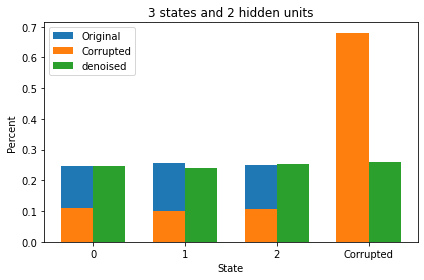

In [7]:
n_hidden = 2
v_model = point_3(corrupted_data,n_hidden)
barplot()

In [8]:
corrupted_data = np.loadtxt('DATA/dataRBM_s5_q0.1.csv', delimiter = ',')
nc_data        = np.loadtxt('DATA/dataRBM_s5.csv', delimiter = ',')

In [ ]:
classes = classes_0[0:4].copy()

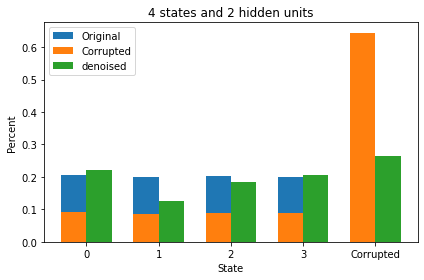

In [9]:
n_hidden = 2
v_model = point_3(corrupted_data,n_hidden)
barplot()

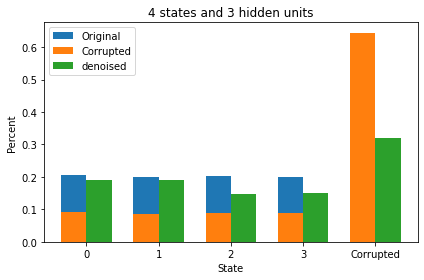

In [10]:
n_hidden = 3
v_model = point_3(corrupted_data,n_hidden)
barplot()

In [11]:
corrupted_data = np.loadtxt('DATA/dataRBM_s6_q0.1.csv', delimiter = ',')
nc_data        = np.loadtxt('DATA/dataRBM_s6.csv', delimiter = ',')

In [ ]:
classes = classes_0[0:5].copy()

In [ ]:
n_hidden = 2
v_model = point_3(corrupted_data,n_hidden)
barplot()

In [ ]:
n_hidden = 3
v_model = point_3(corrupted_data,n_hidden)
barplot()

In [ ]:
n_hidden = 4
v_model = point_3(corrupted_data,n_hidden)
barplot()

### 5 Compare the convergence of the RBM parameters for the case SPINS=True and the case SPINS=False

In [ ]:
# So far we used the spin RBM, now we want to compare spin RBM and no-spin RBM. 
# The data saved in the file is for the no-spin RBM. To train the spin one we have to transform them applying
# the same transfrormation done above: spin_data = 2*nospin_data:
nospin_data = np.loadtxt('DATA/dataRBM_q0.1.csv', delimiter = ',')
spin_data   = 2*nospin_data - 1

# We create both RBM, the only distinction is the input data and the spin value
rbm_spin   = RBM(len(spin_data[0]),3, spin = True)
rbm_nospin = RBM(len(nospin_data[0]),3, spin = False)

# Then we train them plotting only the means square increment of weights over the epochs
plt.subplots(figsize=(12,6)) # sets the dimension
rbm_spin.train(spin_data, n_epochs = 50, batch_size = 500, meansq = True)
rbm_nospin.train(nospin_data, n_epochs = 50, batch_size = 500, meansq = True)
plt.legend(prop={'size': 12})